# Temporal Convolutional Network
In this notebook, we show an example of how TCNs can be used with darts.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import pandas as pd

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, EnergyDataset, SunspotsDataset
from darts.models import TCNModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

## Air passengers dataset

In [3]:
# Read data:
ts = AirPassengersDataset().load()

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("19580801"))

scaler = Scaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
ts_scaled = scaler.transform(ts)

# We'll use the month as a covariate (scaling not required as one-hot-encoded)
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)

In the following cell, we will build a `TCNModel`. Later, when we train it, the model will initiate its internal input width to 2, as we have one dimension for the time series and another dimension for the covariate month time series (this will be transparent to us, though).
Additionally, since we later want to simulate a historic forecast 6 months into the future, we have to make sure the `output_chunk_length` parameter of our `TCNModel` instance has a value of at least 6. 

If we don't specify the `num_layers` parameter, it will be chosen automatically to be the minimum number to ensure full history coverage for every entry in the output, i.e. every output will be dependent on the whole input.

In [4]:
model_name = "TCN_air"
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [5]:
model_air.fit(
    series=train_scaled,
    past_covariates=month_series,
    val_series=val_scaled,
    val_past_covariates=month_series,
)

Training: 0it [00:00, ?it/s]

TCNModel(kernel_size=5, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=13, output_chunk_length=12, n_epochs=500, random_state=0, save_checkpoints=True, model_name=TCN_air, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x2b00e2a40>]})

We'll load the model from the checkpoint that performed best on the validation set.

In [6]:
model_air = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

Let's see what we get for a 6-months prediction:

In [7]:
backtest = model_air.historical_forecasts(
    series=ts_scaled,
    past_covariates=month_series,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

  0%|          | 0/23 [00:00<?, ?it/s]

<Axes: xlabel='time'>

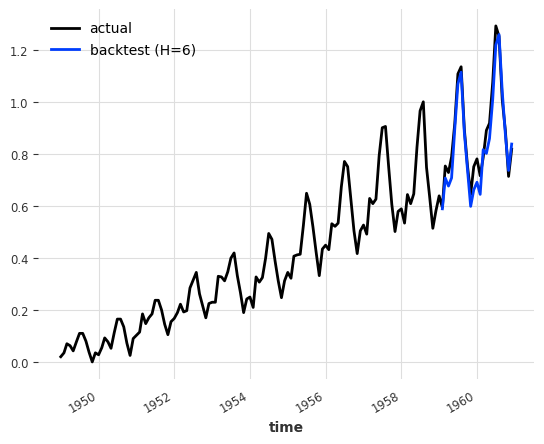

In [8]:
ts_scaled.plot(label="actual")
backtest.plot(label="backtest (H=6)")

## Monthly sunspots
Let's try using the `TCNModel` on a more complex and much bigger dataset.

In [9]:
series_sunspot = SunspotsDataset().load()

train, val = series_sunspot.split_after(pd.Timestamp("19401001"))

scaler = Scaler()

train_sp_transformed = scaler.fit_transform(train)
val_sp_transformed = scaler.transform(val)
series_sp_transformed = scaler.transform(series_sunspot)

In [10]:
model_name = "TCN_sun"
model_sun = TCNModel(
    input_chunk_length=250,
    output_chunk_length=36,
    n_epochs=100,
    dropout=0,
    dilation_base=2,
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [11]:
model_sun.fit(train_sp_transformed, val_series=val_sp_transformed)

Training: 0it [00:00, ?it/s]

TCNModel(kernel_size=3, num_filters=6, num_layers=None, dilation_base=2, weight_norm=True, dropout=0, input_chunk_length=250, output_chunk_length=36, n_epochs=100, nr_epochs_val_period=1, random_state=0, save_checkpoints=True, model_name=TCN_sun, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x176bcc790>]})

In [12]:
model_sun = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [13]:
backtest_sp = model_sun.historical_forecasts(
    series_sp_transformed,
    start=val_sp_transformed.start_time(),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_sp = concatenate(backtest_sp)

  0%|          | 0/43 [00:00<?, ?it/s]

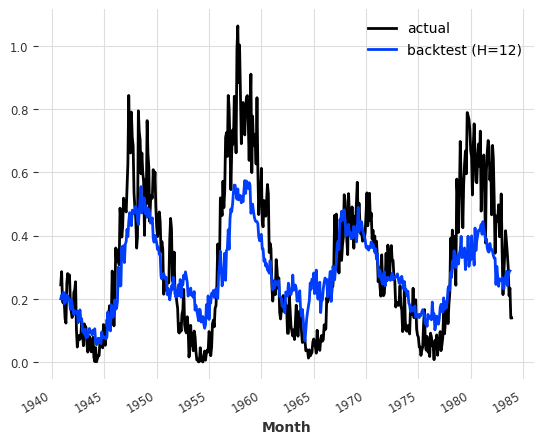

In [14]:
val_sp_transformed.plot(label="actual")
backtest_sp.plot(label="backtest (H=12)")
plt.legend()

## Daily energy production

<Axes: xlabel='time'>

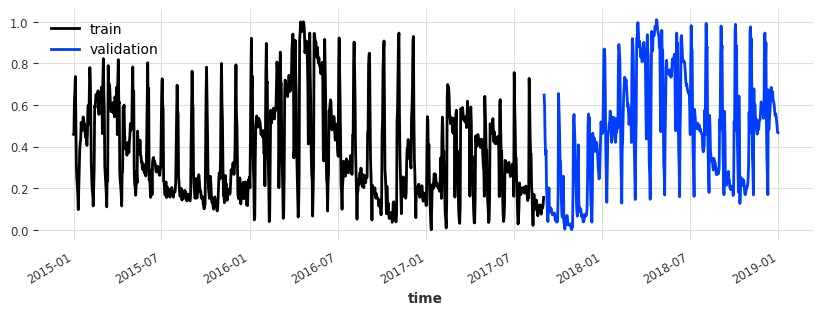

In [15]:
df3 = EnergyDataset().load().to_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# create train and test splits
train_en, val_en = series_en.split_after(pd.Timestamp("20170901"))

# scale the data
scaler_en = Scaler()
train_en_transformed = scaler_en.fit_transform(train_en)
val_en_transformed = scaler_en.transform(val_en)
series_en_transformed = scaler_en.transform(series_en)

# add the day as a covariate (scaling not required as one-hot-encoded)
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)

plt.figure(figsize=(10, 3))
train_en_transformed.plot(label="train")
val_en_transformed.plot(label="validation")

In [16]:
model_name = "TCN_energy"
model_en = TCNModel(
    input_chunk_length=365,
    output_chunk_length=7,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [17]:
model_en.fit(
    series=train_en_transformed,
    past_covariates=day_series,
    val_series=val_en_transformed,
    val_past_covariates=day_series,
)

Training: 0it [00:00, ?it/s]

TCNModel(kernel_size=5, num_filters=8, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=365, output_chunk_length=7, n_epochs=50, nr_epochs_val_period=1, random_state=0, save_checkpoints=True, model_name=TCN_energy, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x2bc722440>]})

In [18]:
model_en = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [19]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    past_covariates=day_series,
    start=val_en_transformed.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_en = concatenate(backtest_en)

  0%|          | 0/69 [00:00<?, ?it/s]

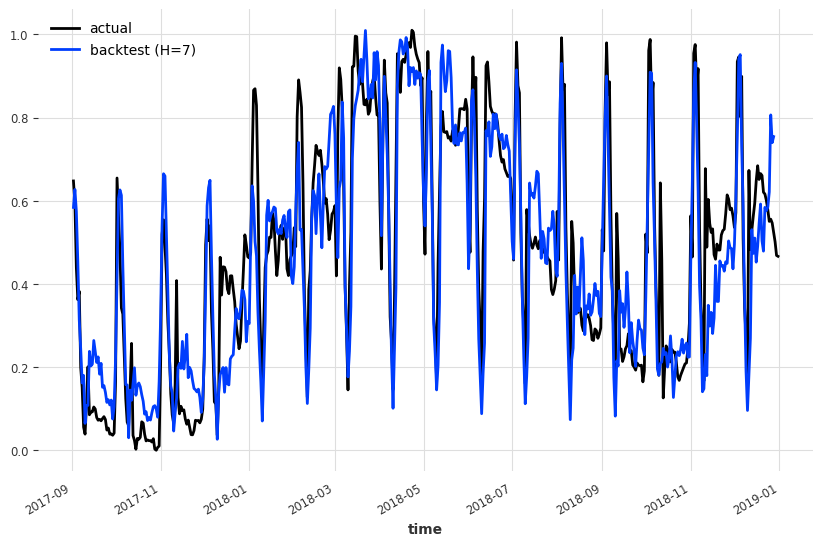

In [20]:
plt.figure(figsize=(10, 6))
val_en_transformed.plot(label="actual")
backtest_en.plot(label="backtest (H=7)")
plt.legend()